# Deploy a TensorFlow SavedModel model trained elsewhere to Amazon SageMaker

Much of the steps below are taken from [this blog post](https://aws.amazon.com/blogs/machine-learning/deploy-trained-keras-or-tensorflow-models-using-amazon-sagemaker/) which explains how to take advantage of Amazon SageMaker deployment capabilities, such as selecting the type and number of instances, performing A/B testing, and Auto Scaling. Auto Scaling clusters are spread across multiple Availability Zones to deliver high performance and high availability.

In this notebook we'll be deploying Microsoft's Megadetector model, saved in SavedModel for TF Serving format, which can be downloaded [here](https://github.com/microsoft/CameraTraps/blob/master/megadetector.md#downloading-the-models). The blog post listed above also demonstrates how to deploy Keras models (JSON and weights hdf5) format to Sagemaker, but that is out of the scope of this notebook.

For more on training the model on SageMaker and deploying, refer to https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-python-sdk/tensorflow_distributed_mnist/tensorflow_distributed_mnist.ipynb

### Step 1. Set up

In the AWS Management Console, go to the Amazon SageMaker console. Choose Notebook Instances, and create a new notebook instance. Upload the current notebook and set the kernel to conda_tensorflow_p36.

The get_execution_role function retrieves the AWS Identity and Access Management (IAM) role you created at the time of creating your notebook instance.

In [2]:
import boto3, re
from sagemaker import get_execution_role

role = get_execution_role()

### Step 2. Convert TensorFlow model to a SageMaker readable format

Download the megadetector model, unzip it, and rename the .pb file to ```saved_model.pb```.

Optionally, you can add an ```inference.py``` file to the ```saved_model_megadetector_v3_tf19/1/``` directory to define pre/post processing scripts. More on that and examples [here](https://github.com/aws/sagemaker-tensorflow-serving-container#prepost-processing). 

Create an export directory structure in the jupyter environment (```export/Servo/```), and upload the contents of the downloaded model there. It should look like

```
export/
    Servo/
        1/
            saved_model.pb
            inference.py
            variables/
            ...
```

TODO:
- Look into passing path of image stored in s3 bucket into inference.py input_handler() and downloading it from s3 there [e.g. here](https://github.com/aws/sagemaker-tensorflow-serving-container/issues/73)

In [ ]:
!mkdir export

In [ ]:
!mkdir export/Servo

In [ ]:
!mkdir export/Servo/1

In [ ]:
!mkdir export/Servo/1/variables

####  Tar the entire directory and upload to S3

In [53]:
import tarfile
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('export', recursive=True)

In [54]:
import sagemaker

sagemaker_session = sagemaker.Session()
inputs = sagemaker_session.upload_data(path='model.tar.gz', key_prefix='model')

### Step 3. Deploy the trained model

There are [two ways to deploy models to sagemaker](https://docs.aws.amazon.com/sagemaker/latest/dg/ex1-deploy-model.html), using the AWS Sagemaker Python SDK (what we use below), or using the AWS SDK for Python (Boto 3). Boto 3 offers more lower level configuration controls. Documentation on using the Sagemaker Python SDK for deployment can be found [here](https://sagemaker.readthedocs.io/en/stable/using_tf.html#deploy-to-a-sagemaker-endpoint).

TODO: 
- look into using Elastic Inference (https://docs.aws.amazon.com/sagemaker/latest/dg/ei.html) for low-cost fast inference without using a GPU instance

NOTES: 
- The entry_point file "train.py" can be an empty Python file. It's used as an alternative ```entry_point``` if you don't use an inference.py file. The requirement will be removed at a later date.
- Ignore the warning about python 3 and do not set the py_version argument

In [5]:
!touch train.py

In [57]:
from sagemaker.tensorflow.model import TensorFlowModel
sagemaker_model = TensorFlowModel(model_data = 's3://' + sagemaker_session.default_bucket() + '/model/model.tar.gz',
                                  role = role,
                                  framework_version = '1.12',
                                  entry_point = 'export/Servo/inference.py')

2.0.0 is the latest version of tensorflow that supports Python 2. Newer versions of tensorflow will only be available for Python 3.Please set the argument "py_version='py3'" to use the Python 3 tensorflow image.


In [58]:
%%time
predictor = sagemaker_model.deploy(initial_instance_count=1,
                                   instance_type='ml.m4.xlarge',
                                  )

-----------!CPU times: user 320 ms, sys: 4.08 ms, total: 324 ms
Wall time: 5min 32s


### Step 4. Invoke the endpoint

Grab the newly created endpoint name from the Amazon Sagemaker Console and plug it in below:

In [85]:
endpoint_name = 'sagemaker-tensorflow-2020-03-13-05-52-15-007'

#### Create a predictor from the endpoint

In [86]:
# import sagemaker
# from sagemaker.tensorflow.model import TensorFlowModel
# predictor=sagemaker.tensorflow.model.TensorFlowPredictor(endpoint_name, sagemaker_session)

import sagemaker
from sagemaker.predictor import RealTimePredictor, npy_serializer, numpy_deserializer
predictor = RealTimePredictor(endpoint_name, 
                              serializer=npy_serializer, 
                              deserializer=numpy_deserializer)

#### Make sure we have a test image

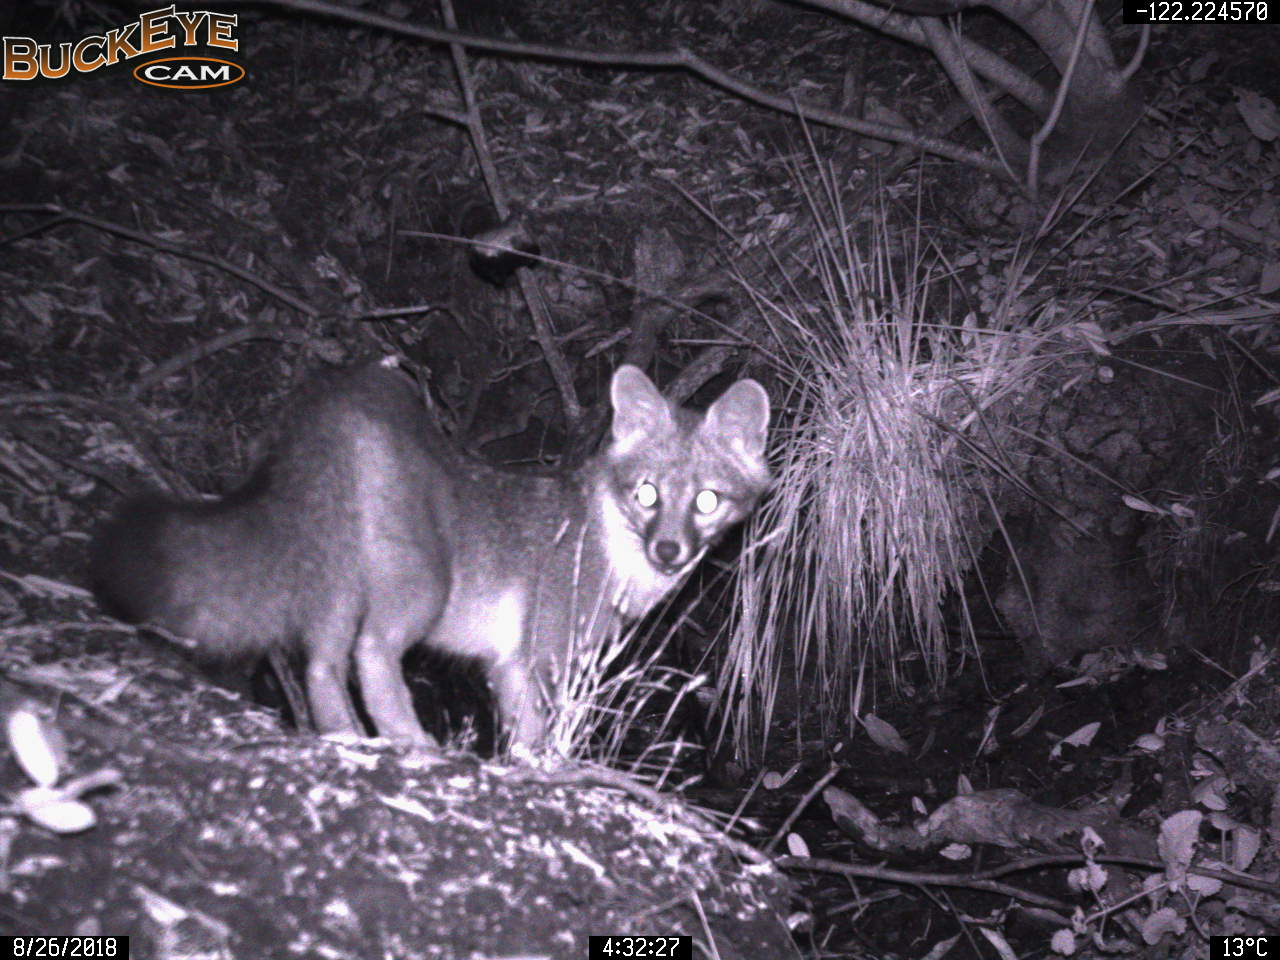

In [61]:
# from IPython.display import display, Image

# test_img = 'test_data/test.jpg'

# display(Image(filename=test_img))

#### Invoke the SageMaker endpoint using a boto3 client

NOTE: still working on figuring out exactly how to pass the correct data signature into the model endpoint. I hoped that by adding an ```input_handler``` in the inference.py file I'd be able to debug by printing out the incoming request body from within the [sagemaker-tensorflow-serving-container](https://github.com/aws/sagemaker-tensorflow-serving-container), but it doesn't seem to print out in the Cloud Watch logs. Perhaps I didn't configure the inference.py correctly. More info [here](https://github.com/aws/sagemaker-python-sdk/blob/master/doc/using_tf.rst#how-to-implement-the-pre-and-or-post-processing-handler-s).

My (very basic) understanding of how the data should flow is: 
1. request is made from client. Note sure if the body data type and format matters a ton here, but I have had trouble attempting to make requests with ```ContentType='application/x-image'```, despite this being an interceptible content type I've seen in input_handler examples. In general though, sagemaker-tensorflow-serving-container wants ```ContentType='application/json'```. 
2. request body is intercepted by input_handler, processed, and passed along to the model in a format that [Tensorflow's RESTful API](https://www.tensorflow.org/tfx/serving/api_rest#predict_api) likes (basically json object with the data set to the value of an 'instances' key)
3. According to the megadetector docs, it says it expects inputs in uint8 format...

I was also never able to inspect the model's signature definition on my local computer with the tensorflow ```saved_model_cli``` (I got the response "SavedModel file does not exist at:saved_model_megadetector_v3_ft19/1/"). I was, howefver, able to run it on the other Megadetector SavedModel (the one NOT for TF Serving): ```saved_model_cli show --dir saved_model_normalized_megadetector_v3_tf19```, but it responds with "The given SavedModel contains the following tag-sets: ". Never got further than that. Being able to inspect the signature def might shed some light into the format the model expects.


In [104]:
import json
import boto3
import numpy as np
import io
import cv2
from PIL import Image
import sys


client = boto3.client('runtime.sagemaker')

# Approach 1 - from https://github.com/morenoh149/tensorflow-sagemaker/blob/master/Explore%20and%20Train.ipynb
# read the image files into a tensor (numpy array)
#
# def image_file_to_tensor(path, dims):
#     """Reads an image file path and target dimensions as a tuple
#     returns a tensor (ndarray)
#     Args: 
#         path (str): The file name or path to the image file.
#     """
#     image = cv2.imread(path)
#     image = cv2.resize(image, dsize=dims, interpolation=cv2.INTER_CUBIC)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = np.asarray(image)
#     image = cv2.normalize(image.astype('float'), None, 0, 1, cv2.NORM_MINMAX)
#     image = np.expand_dims(image, axis=0)
#     return image
#
# img = image_file_to_tensor(test_img, (226,226)) # Invalid type for parameter Body
# print(img.shape)

# Approach 2 - Load the image bytes
# img = open(test_img, 'rb').read() # returns ERROR in serving: 'utf8' codec can't decode byte 0xff in position 0: invalid start byte

# Approach 3 - attempt from https://github.com/microsoft/CameraTraps/tree/master/api/detector_synchronous/api_tfserving
im = Image.open(test_img)
print('original image size: ', im.size)
size = 300, 300
im = im.resize(size)
print('image size: ', im.size)
np_im = np.asarray(im, np.uint8)
np_im_plus_dim = np.expand_dims(np_im, axis=0)
print('image type: ', type(np_im_plus_dim))
print('image dtype: ', np_im_plus_dim.dtype)
print('image dim: ', np_im_plus_dim.ndim)
print('image shape: ', np_im_plus_dim.shape)
data = json.dumps({'signature_name': 'serving_default', 'instances': np_im_plus_dim.tolist()})
print('Data: {} ... {}'.format(data[:50], data[len(data)-52:]))
print('size of data: ', sys.getsizeof(data))

response = client.invoke_endpoint(
    EndpointName=endpoint_name,
#     ContentType='application/x-image', 
    Body=data
)

response_body = response['Body']
print(response_body.read())

original image size:  (1280, 960)
image size:  (300, 300)
image type:  <class 'numpy.ndarray'>
image dtype:  uint8
image dim:  4
image shape:  (1, 300, 300, 3)
Data: {"signature_name": "serving_default", "instances": ... , 5], [0, 0, 0], [3, 3, 3], [0, 0, 0], [0, 0, 0]]]]}
size of data:  1327180


ModelError: An error occurred (ModelError) when calling the InvokeEndpoint operation: Received server error (500) from model with message "". See https://us-west-1.console.aws.amazon.com/cloudwatch/home?region=us-west-1#logEventViewer:group=/aws/sagemaker/Endpoints/sagemaker-tensorflow-2020-03-13-05-52-15-007 in account 719729260530 for more information.